In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import warnings
import pickle
from matplotlib import container

# from functools import partial

plt.rcParams['figure.figsize'] = (6, 4)  # 8*4
plt.rcParams['figure.dpi'] = 100

output_format=".eps"

In [77]:
def make_dir(file_or_dir):
    """Given a dir or file path, creates the dir if needed and returns de original string"""
    results_dir=os.path.dirname(file_or_dir)
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    return file_or_dir

In [78]:
styledict_exp1=dict(marker='x',color='black',linestyle='None',
ecolor=(0, 0, 0, 0.4),elinewidth=1,capsize=2.5,)


styledict_exp2=styledict_exp1.copy()
styledict_exp2.update(dict(marker='^',ecolor=(0, 0, 0, 0.4),ms=4))

ls1='--'
ls2='-.'

In [79]:
r0dict={}
r0errdict={}

In [80]:
def get_V(B,r0):
    return np.exp(-3.44*(B/r0)**(5/3))

In [81]:
def get_err(pcov):
    """Metodo correcto de calcular el error segun la documentación."""
    return np.sqrt(np.diag(pcov))[0]

In [82]:
B=np.linspace(0,0.32,1000)


In [83]:
df=pd.read_hdf('intermedio/tabla_arturo.h5', 'df')
print(df.keys())
dispcols=['Imagen','Objeto','DATE','Filtro','L (mm)','V_media','S','E_acc','D (mm)']

Index(['Objeto', 'Filtro', 'Disco', 'D (mm)', 'L (mm)', 'L1 (mm)', 'L2 (mm)',
       'Notas', 'PATH', 'Imagen', '$\lambda$', '$d\lambda$', 'alphap',
       'alphap_mas', 'filtername', 'starname', 'DATE', 'DAY', 'HOUR',
       'csv_path', 'V_media', 'S', 'S_tip', 'E_acc'],
      dtype='object')


# Arturo

In [84]:
cond=(df['V_media']>0) 
df_sel=df.loc[cond]
df_sel[dispcols]

,Imagen,Objeto,DATE,Filtro,L (mm),V_media,S,E_acc,D (mm)
Imagen,,,,,,,,,
1,1,Arturo,22-07-02,Halfa-7 nm,310.0,0.057449,0.029049,0.020781,30
2,2,Arturo,22-07-02,Halfa-7 nm,230.0,0.098542,0.025492,0.018236,30
3,3,Arturo,22-07-02,Halfa-7 nm,150.0,0.093816,0.031957,0.022861,30
4,4,Arturo,22-07-02,Halfa-7 nm,270.0,0.070075,0.032532,0.023272,30
5,5,Arturo,22-07-02,Halfa-7 nm,190.0,0.118105,0.036563,0.026156,30
6,6,Arturo,22-07-02,Halfa-7 nm,60.0,0.457721,0.074450,0.053259,30
7,7,Arturo,22-07-02,Halfa-7 nm,40.0,0.673463,0.064162,0.045899,30
8,8,Arturo,22-07-02,Halfa-7 nm,190.0,0.089529,0.047105,0.033697,30


C:\Users\ivian\AppData\Local\Temp\ipykernel_15032\1427159106.py:15: UserWarning: Calculando r0 para una imagen dos veces
  warnings.warn("Calculando r0 para una imagen dos veces")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


r0= 0.15306185936327987


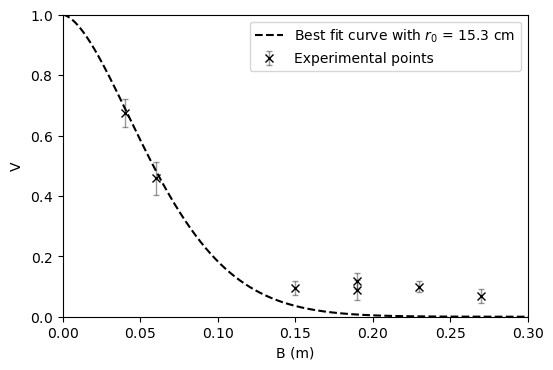

In [98]:
B_exp=df_sel['L (mm)']/1000
V_exp=df_sel['V_media']

popt, pcov =curve_fit(get_V, B_exp,V_exp,p0=0.2,bounds=(0.01,1))

##########################
# OVERRIDE !!!!!!!!!!
# popt[0]=0.3
##########################

print("r0=",*popt)
V_fit=get_V(B,popt[0])
for n in df_sel['Imagen']:
    if n in r0dict:
        warnings.warn("Calculando r0 para una imagen dos veces")
    r0dict[n]=popt[0]
    r0errdict[n]=get_err(pcov)
    
fig, ax = plt.subplots()
plt.ticklabel_format(useMathText=True)
plt.xlim([0, 0.3])
plt.ylim([0, 1])

plt.plot(B, V_fit,ls1,c='black',label=f"Best fit curve with $r_0$ = {100*popt[0]:0.1F} cm")
plt.errorbar(B_exp, V_exp, yerr=df_sel['E_acc'],label="Experimental points",**styledict_exp1)

ax.legend()
date=df_sel['DATE'].iloc[0]
# ax.set_title(f'Sirius ({date})')
ax.set_xlabel("B (m)")
ax.set_ylabel("V")
plt.savefig(make_dir("productos/ajustes/ajuste-arturo"+output_format))

In [86]:
with open('intermedio/valoresr0.pkl', 'wb') as f:
    pickle.dump(r0dict, f)

In [87]:
valoresr0=pd.DataFrame(r0dict.values(),index=r0dict.keys(),columns=["r0"])




In [88]:
erroresr0=pd.DataFrame(r0errdict.values(),index=r0errdict.keys(),columns=["error"])


In [89]:
r0df=valoresr0.join(erroresr0)
with open('productos/valoresr0.json','wb') as f:
    r0df.to_json(f,indent=4)
r0df.to_excel("productos/r0errors.xlsx",engine="openpyxl")
r0df

,r0,error
1,0.153062,0.015582
2,0.153062,0.015582
3,0.153062,0.015582
4,0.153062,0.015582
5,0.153062,0.015582
6,0.153062,0.015582
7,0.153062,0.015582
8,0.153062,0.015582


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


r0= 0.3


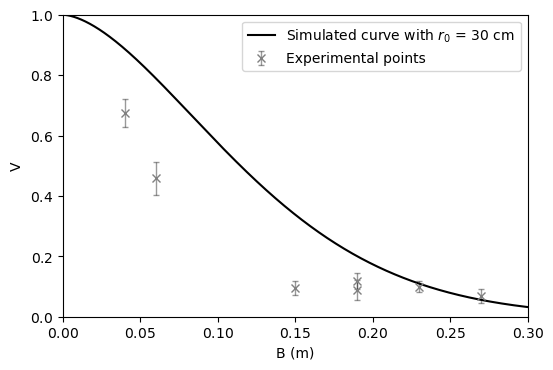

In [97]:
B_exp=df_sel['L (mm)']/1000
V_exp=df_sel['V_media']

popt, pcov =curve_fit(get_V, B_exp,V_exp,p0=0.2,bounds=(0.01,1))

##########################
# OVERRIDE !!!!!!!!!!
popt[0]=0.3
##########################

print("r0=",*popt)
V_fit=get_V(B,popt[0])
# for n in df_sel['Imagen']:
#     if n in r0dict:
#         warnings.warn("Calculando r0 para una imagen dos veces")
#     r0dict[n]=popt[0]
#     r0errdict[n]=get_err(pcov)
    
fig, ax = plt.subplots()
plt.ticklabel_format(useMathText=True)
plt.xlim([0, 0.3])
plt.ylim([0, 1])

plt.plot(B, V_fit,# ls1,
    c='black',label=f"Simulated curve with $r_0$ = {popt[0]*100:0.0F} cm")
plt.errorbar(B_exp, V_exp, yerr=df_sel['E_acc'],label="Experimental points",
**dict(marker='x',color='gray',linestyle='None',ecolor=(0, 0, 0, 0.4),elinewidth=1,capsize=2.5,))

ax.legend()
date=df_sel['DATE'].iloc[0]
# ax.set_title(f'Sirius ({date})')
ax.set_xlabel("B (m)")
ax.set_ylabel("V")
plt.savefig(make_dir("productos/ajustes/SIMULACION-ARTURO"+f"{popt[0]}"+output_format))

In [126]:
def get_seeing(r0):
    lb=df_sel["$\\lambda$"].iloc[0]*1e-9
    seeing_rad= 0.98*lb/r0
    seeing_as=seeing_rad*206265
    return seeing_as
get_seeing(0.153)


0.8670617284686274

In [131]:
r0=0.1
print(f"{r0=}")
seeing=get_seeing(r0)
print(f'seeing={seeing:0.2f}"')

r0=0.1
seeing=1.33"


In [132]:
r0=0.35
print(f"{r0=}")
seeing=get_seeing(r0)
print(f'seeing={seeing:0.2f}"')

r0=0.35
seeing=0.38"


Un seeing de <0.4 arcsec se considera excelente. Esto corresponde con un parametro de fried >0.33

In [114]:
df_sel["$\\lambda$"].iloc[0]*1e-9

6.56281e-07